<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_26_Multi_task_Learning/notebooks/Day_26_Multi_task_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 26 - Multi-Task Learning with MNIST

### SETUP

In [1]:
# ----------
# SETUP
# ----------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train_digit), (x_test, y_test_digit) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### CREATE MULTI-TASK LABELS

In [2]:
# ----------
# CREATE MULTI-TASK LABELS
# ----------
# Task 1: Digit classification (0-9)
y_train_digit = tf.keras.utils.to_categorical(y_train_digit, 10)
y_test_digit = tf.keras.utils.to_categorical(y_test_digit, 10)

# Task 2: Parity classification (even=0, odd=1)
y_train_parity = np.array([1 if x%2 == 1 else 0 for x in np.argmax(y_train_digit, axis=1)])
y_test_parity = np.array([1 if x%2 == 1 else 0 for x in np.argmax(y_test_digit, axis=1)])

### BUILD MULTI-TASK MODEL

In [3]:
# ----------
# BUILD MULTI-TASK MODEL
# ----------
def build_multi_task_model():
    inputs = layers.Input(shape=(28, 28, 1))

    # Shared Backbone
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    shared = layers.Dense(128, activation='relu')(x)

    # Task-specific Heads
    # Head 1: Digit Classification (10 classes)
    digit_head = layers.Dense(10, activation='softmax', name='digit')(shared)

    # Head 2: Parity Classification (Binary)
    parity_head = layers.Dense(1, activation='sigmoid', name='parity')(shared)

    return models.Model(inputs=inputs, outputs=[digit_head, parity_head])

model = build_multi_task_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1600)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    204,928 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit (Dense)       │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parity (Dense)      │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,163 (879.54 KB)

 Trainable params: 225,163 (879.54 KB)

 Non-trainable params: 0 (0.00 B)

### COMPILE MODEL

In [4]:
# ----------
# COMPILE MODEL
# ----------
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss={
        'digit': 'categorical_crossentropy',
        'parity': 'binary_crossentropy'
    },
    loss_weights={'digit': 0.5, 'parity': 0.5},
    metrics={
        'digit': 'accuracy',
        'parity': 'accuracy'
    }
)

### TRAIN MODEL

In [5]:
# ----------
# TRAIN MODEL
# ----------
history = model.fit(
    x_train,
    {'digit': y_train_digit, 'parity': y_train_parity},
    validation_split=0.2,
    batch_size=128,
    epochs=15,
    verbose=1
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - digit_accuracy: 0.8330 - digit_loss: 0.5818 - loss: 0.4157 - parity_accuracy: 0.8880 - parity_loss: 0.2496 - val_digit_accuracy: 0.9769 - val_digit_loss: 0.0787 - val_loss: 0.0625 - val_parity_accuracy: 0.9837 - val_parity_loss: 0.0467
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - digit_accuracy: 0.9777 - digit_loss: 0.0742 - loss: 0.0597 - parity_accuracy: 0.9843 - parity_loss: 0.0452 - val_digit_accuracy: 0.9831 - val_digit_loss: 0.0561 - val_loss: 0.0445 - val_parity_accuracy: 0.9891 - val_parity_loss: 0.0334
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - digit_accuracy: 0.9860 - digit_loss: 0.0467 - loss: 0.0379 - parity_accuracy: 0.9896 - parity_loss: 0.0291 - val_digit_accuracy: 0.9837 - val_digit_loss: 0.0559 - val_loss: 0.0421 - val_parity_accuracy: 0.9908 - val_parity_loss: 0.0289
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - digit_accuracy: 0.9885 - digit_loss: 0.0342 - loss: 0.0277 - parity_accuracy

### EVALUATION

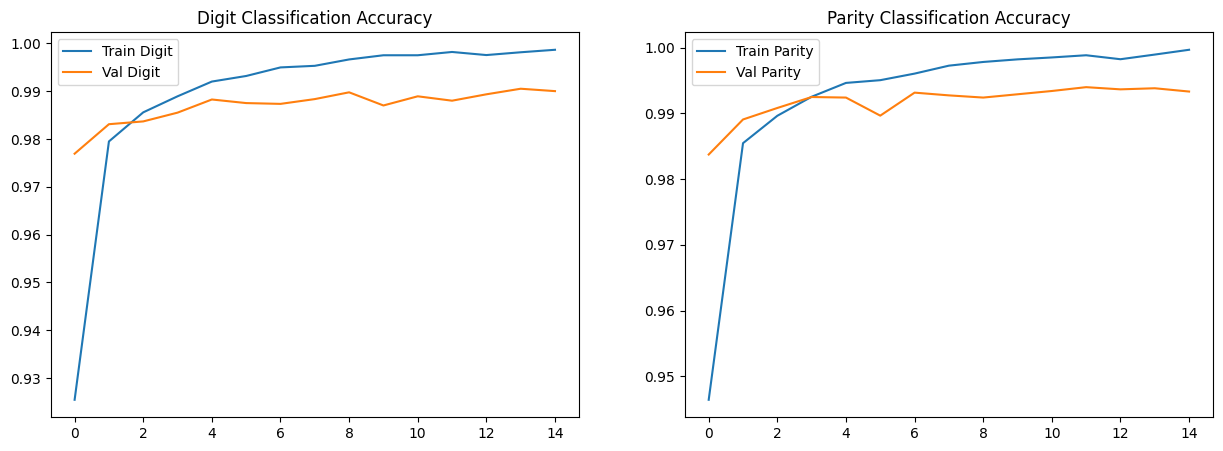


Test Accuracy - Digits: 0.9900, Parity: 0.9948


In [8]:
# ----------
# EVALUATION
# ----------
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Digit accuracy
    ax1.plot(history.history['digit_accuracy'], label='Train Digit')
    ax1.plot(history.history['val_digit_accuracy'], label='Val Digit')
    ax1.set_title('Digit Classification Accuracy')
    ax1.legend()

    # Parity accuracy
    ax2.plot(history.history['parity_accuracy'], label='Train Parity')
    ax2.plot(history.history['val_parity_accuracy'], label='Val Parity')
    ax2.set_title('Parity Classification Accuracy')
    ax2.legend()
    plt.savefig('history.png')
    plt.show()

plot_history(history)

# Test evaluation
test_results = model.evaluate(
    x_test,
    {'digit': y_test_digit, 'parity': y_test_parity},
    verbose=0
)

print(f"\nTest Accuracy - Digits: {test_results[3]:.4f}, Parity: {test_results[4]:.4f}")

### PREDICTION DEMO

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


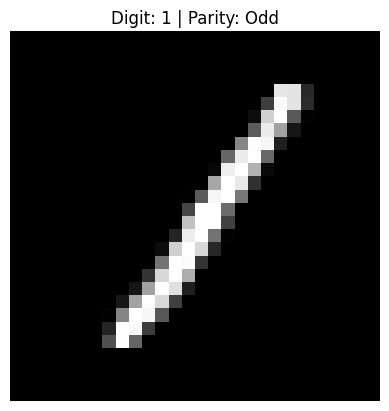

In [9]:
# ----------
# PREDICTION DEMO
# ----------
sample_idx = np.random.randint(0, len(x_test))
sample_img = x_test[sample_idx]
digit_pred, parity_pred = model.predict(np.expand_dims(sample_img, axis=0))

plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Digit: {np.argmax(digit_pred)} | Parity: {'Odd' if parity_pred > 0.5 else 'Even'}")
plt.axis('off')
plt.savefig('prediction.png')
plt.show()